<a href="https://colab.research.google.com/github/guscldns/TestProject/blob/main/0525/0525_01_6_%E1%84%86%E1%85%A5%E1%84%89%E1%85%B5%E1%86%AB%E1%84%85%E1%85%A5%E1%84%82%E1%85%B5%E1%86%BC_%E1%84%8B%E1%85%A1%E1%86%BC%E1%84%89%E1%85%A1%E1%86%BC%E1%84%87%E1%85%B3%E1%86%AF(%E1%84%89%E1%85%B5%E1%86%AF%E1%84%89%E1%85%B3%E1%86%B8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# matplotlib과 관련된 모듈을 미리 선언
import matplotlib.pyplot as plt
import numpy as np

## Ensemble(앙상블)

단일 모델을 사용하여 과적합이 나타날 가능성이 높다면,
여러 개의 의사결정 나무를 같이 사용해보면 어떨까? = 앙상블 기법

- 앙상블 기법
: 과적합 방지 및 더 높은 성능의 결과를 도출하도록 여러 모델을 활용하는 기법

- 대표적인 앙상블 기법
: Voting(투표), Bagging(Bootstrap Aggregating), Boosting

#### 1. Voting (투표) 
- 여러 모델의 예측 결과값을 활용하여 투표를 통해 최종 예측값 결정
- 결과가 직관적이며 해석이 쉽고, 평균, 다수결 채택 등의 간단한 연산을 사용함

- (예를 들어) 
    - 회귀 : 여러 모델들의 예측값의 평균
    - 분류 : 다수결 or 확률의 평균

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 개별 모델은 로지스틱 회귀와 SVC 임. 
lr_clf = LogisticRegression(solver='liblinear')
svc_clf = SVC()


# 개별 모델을 하드 보팅 기반의 앙상블 모델로 구현한 분류기 
# 하드 보팅은 확률 리턴, 분류만 제공하는 모델에서는 사용할 수 없다
vo_clf = VotingClassifier( 
    estimators=[('LR',lr_clf),('SVC',svc_clf)] , 
    voting='hard' )

In [ ]:
vo_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('LR', LogisticRegression(solver='liblinear')),
                             ('SVC', SVC(probability=True))],
                 voting='soft')

In [ ]:
vo_clf.predict(X_test)

In [ ]:
vo_clf.predict_proba(X_test)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 개별 모델은 로지스틱 회귀와 SVC 임. 
lr_clf = LogisticRegression(solver='liblinear')
svc_clf = SVC(probability=True) # SVC는 기본적으로 확률을 리턴해주지 않기 때문에 이를 True로 설정해줘야 함. 

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_clf = VotingClassifier( estimators=[('LR',lr_clf),('SVC',svc_clf)] , voting='hard' )

In [ ]:
# VotingClassifier 학습/예측/평가. 
from sklearn.metrics import accuracy_score

vo_clf.fit(X_train , y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

Voting 분류기 정확도: 0.9649


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        43
           1       0.95      1.00      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



In [ ]:
# 개별 모델의 학습/예측/평가.
classifiers = [lr_clf, svc_clf]
for classifier in classifiers:
    classifier.fit(X_train , y_train)
    pred = classifier.predict(X_test)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))

LogisticRegression 정확도: 0.9561
SVC 정확도: 0.9474


#### 2. Bagging (배깅) : Bootstrap + Aggregating

- Bootstrap : 원본 데이터 집단으로부터 원본과 유사한 새로운 데이터 집단을 추출하는 것이다.
- Aggregating : ‘모으다’, ‘합치다’라는 의미이다. 

    
즉, Bagging이란 
- 복원 추출을 통해 랜덤 추출한 데이터를 생성하고(Bootstrap), 
- 각 데이터를 모델 학습하여 결합한 후 (Aggregating),
- 학습된 모델의 예측 변수를 활용하여 최종 모델을 생성하는 방법

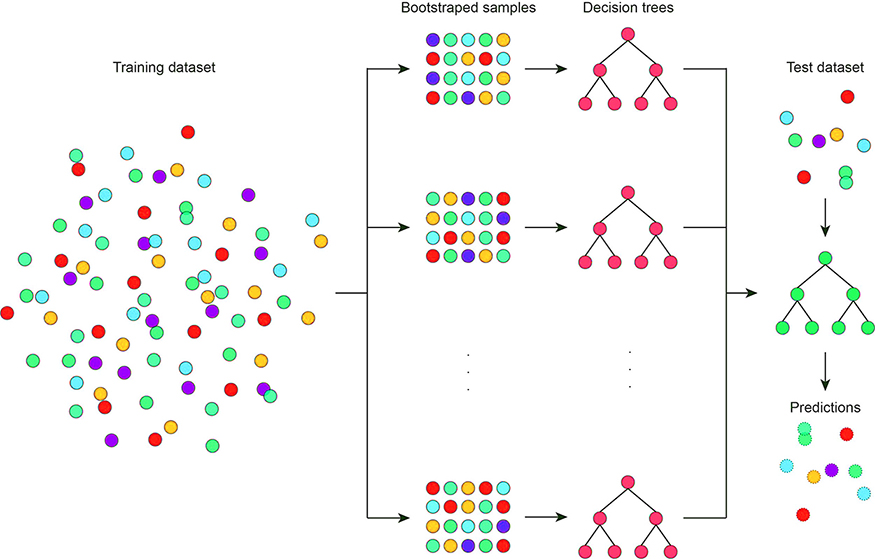

- 이미지 출처 : https://learnetutorials.com/machine-learning/bagging-and-random-forest

#### Bagging의 대표 모델 : Random Forest 

부트스트랩으로 만들어진 여러 샘플 데이터를 가지고, 여러번의 Decision Tree를 수행한다음 이를 Aggregation하는 것이 Random Forest이다.

1. 학습 데이터 N개로부터 중복을 허용하여 무작위로 샘플 데이터 N개를 추출한다.
2. 샘플 데이터에서 중복을 허용하지 않고, 무작위로 X 값(input feature) d개를 선택한다.
3. d개의 feature에 대해 Decision Tree를 수행한다.
4. 위의 1-3 과정을 K번 수행한다.

Bagging의 특징 
- Bootstrap을 활용한 랜덤 샘플링으로 과적합(Overfitting) 방지
- 복원 과정이 있어 불균형하거나 충분하지 않은 데이터에 적용 가능
- 병렬처리 가능

`class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=None)`

주요 paramter:
  - 랜덤 포레스트의 파라미터는 BaggingClassifier와 DecisionTreeClassifier를 제어하는 파라미터를 모두 가지고 있다.(splitter, presort, max_samples, base_estimator를 제외한다.)
  - `n_estimators` : 트리의 수를 설정한다.(Bagging 과 DecisionTree의 결합이기 때문에)
  - `max_features` : 각 노드에서 선택하는 특성의 수 (무작위 선택), max_features의 값이 커지면 각 트리들은 비슷해지고, 값을 낮추면 트리들이 서로 많이 달라지고 데이터에 맞추기 위해 깊이가 깊어지게 된다.

참고: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target,
                                                   test_size = 0.3,
                                                   shuffle = True, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 깊이가 1인 결정트리 100개 만들어서 Random Forest를 학습시키세요
# 단 max_features = 2 
forest = RandomForestClassifier(100, max_depth = 1, max_features = 2)

In [ ]:
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=1, max_features=2)

In [ ]:
forest.score(X_train, y_train)

0.9428571428571428

In [ ]:
forest.score(X_test, y_test)

0.9777777777777777

In [ ]:
y_pred = forest.predict(X_test)[:10]
y_pred

array([1, 0, 2, 1, 2, 0, 1, 2, 1, 1])

In [ ]:
forest.predict_proba(X_test)[:10]

# 각 학습기를 합쳐서 나눈 것; 0일 확률 0.009, 1일 확률 0.5, 2일 확률 0.48

array([[0.09528449, 0.50362973, 0.40108579],
       [0.70902193, 0.19662274, 0.09435533],
       [0.00547942, 0.38875195, 0.60576863],
       [0.09117734, 0.49896136, 0.4098613 ],
       [0.06194541, 0.46362807, 0.47442652],
       [0.81948627, 0.1608064 , 0.01970733],
       [0.10158078, 0.50304149, 0.39537773],
       [0.00547942, 0.38875195, 0.60576863],
       [0.09117734, 0.49896136, 0.4098613 ],
       [0.10158078, 0.50304149, 0.39537773]])

In [ ]:
forest.feature_importances_

array([0.17, 0.01, 0.49, 0.33])

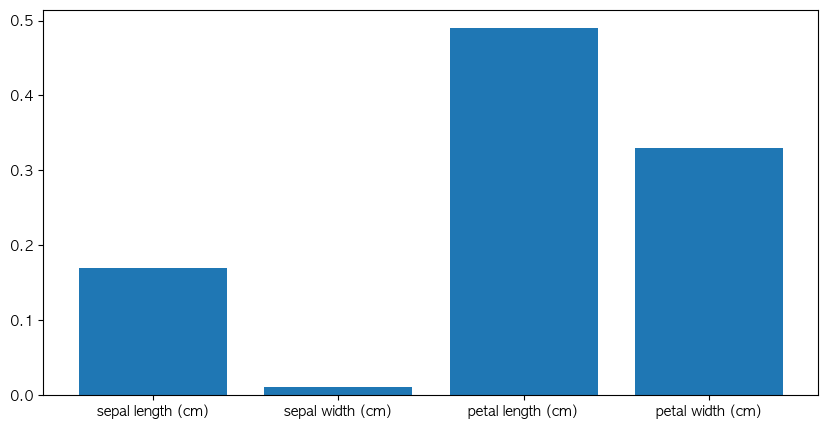

In [ ]:
# 특성 중요도 그래프 그리기
plt.figure(figsize =(10,5))
plt.bar(iris.feature_names, forest.feature_importances_)
plt.show()

#### 3. Boosting 

- Bagging과의 공통점
    - 원본 데이터 집단으로부터 원본과 유사한 새로운 데이터 집단을 K번 추출하여 K번의 약학습기 학습을 진행한다

- Bagging과의 차이점
    - Bagging은 K번의 샘플링을 독립적으로 수행하지만, Boosting은 순차적으로 먼저 진행한 샘플링을 통해 먼저 학습한다. 
    - 학습한 결과에서 오차가 발생한 데이터에 가중치를 더 강하게 준 다음, 다음 샘플링을 수행한다.
    - 즉, 오차가 발생했던 데이터가 다음 번에 또 뽑힌다면 또 틀리지는 않도록 학습한다는 의미다.

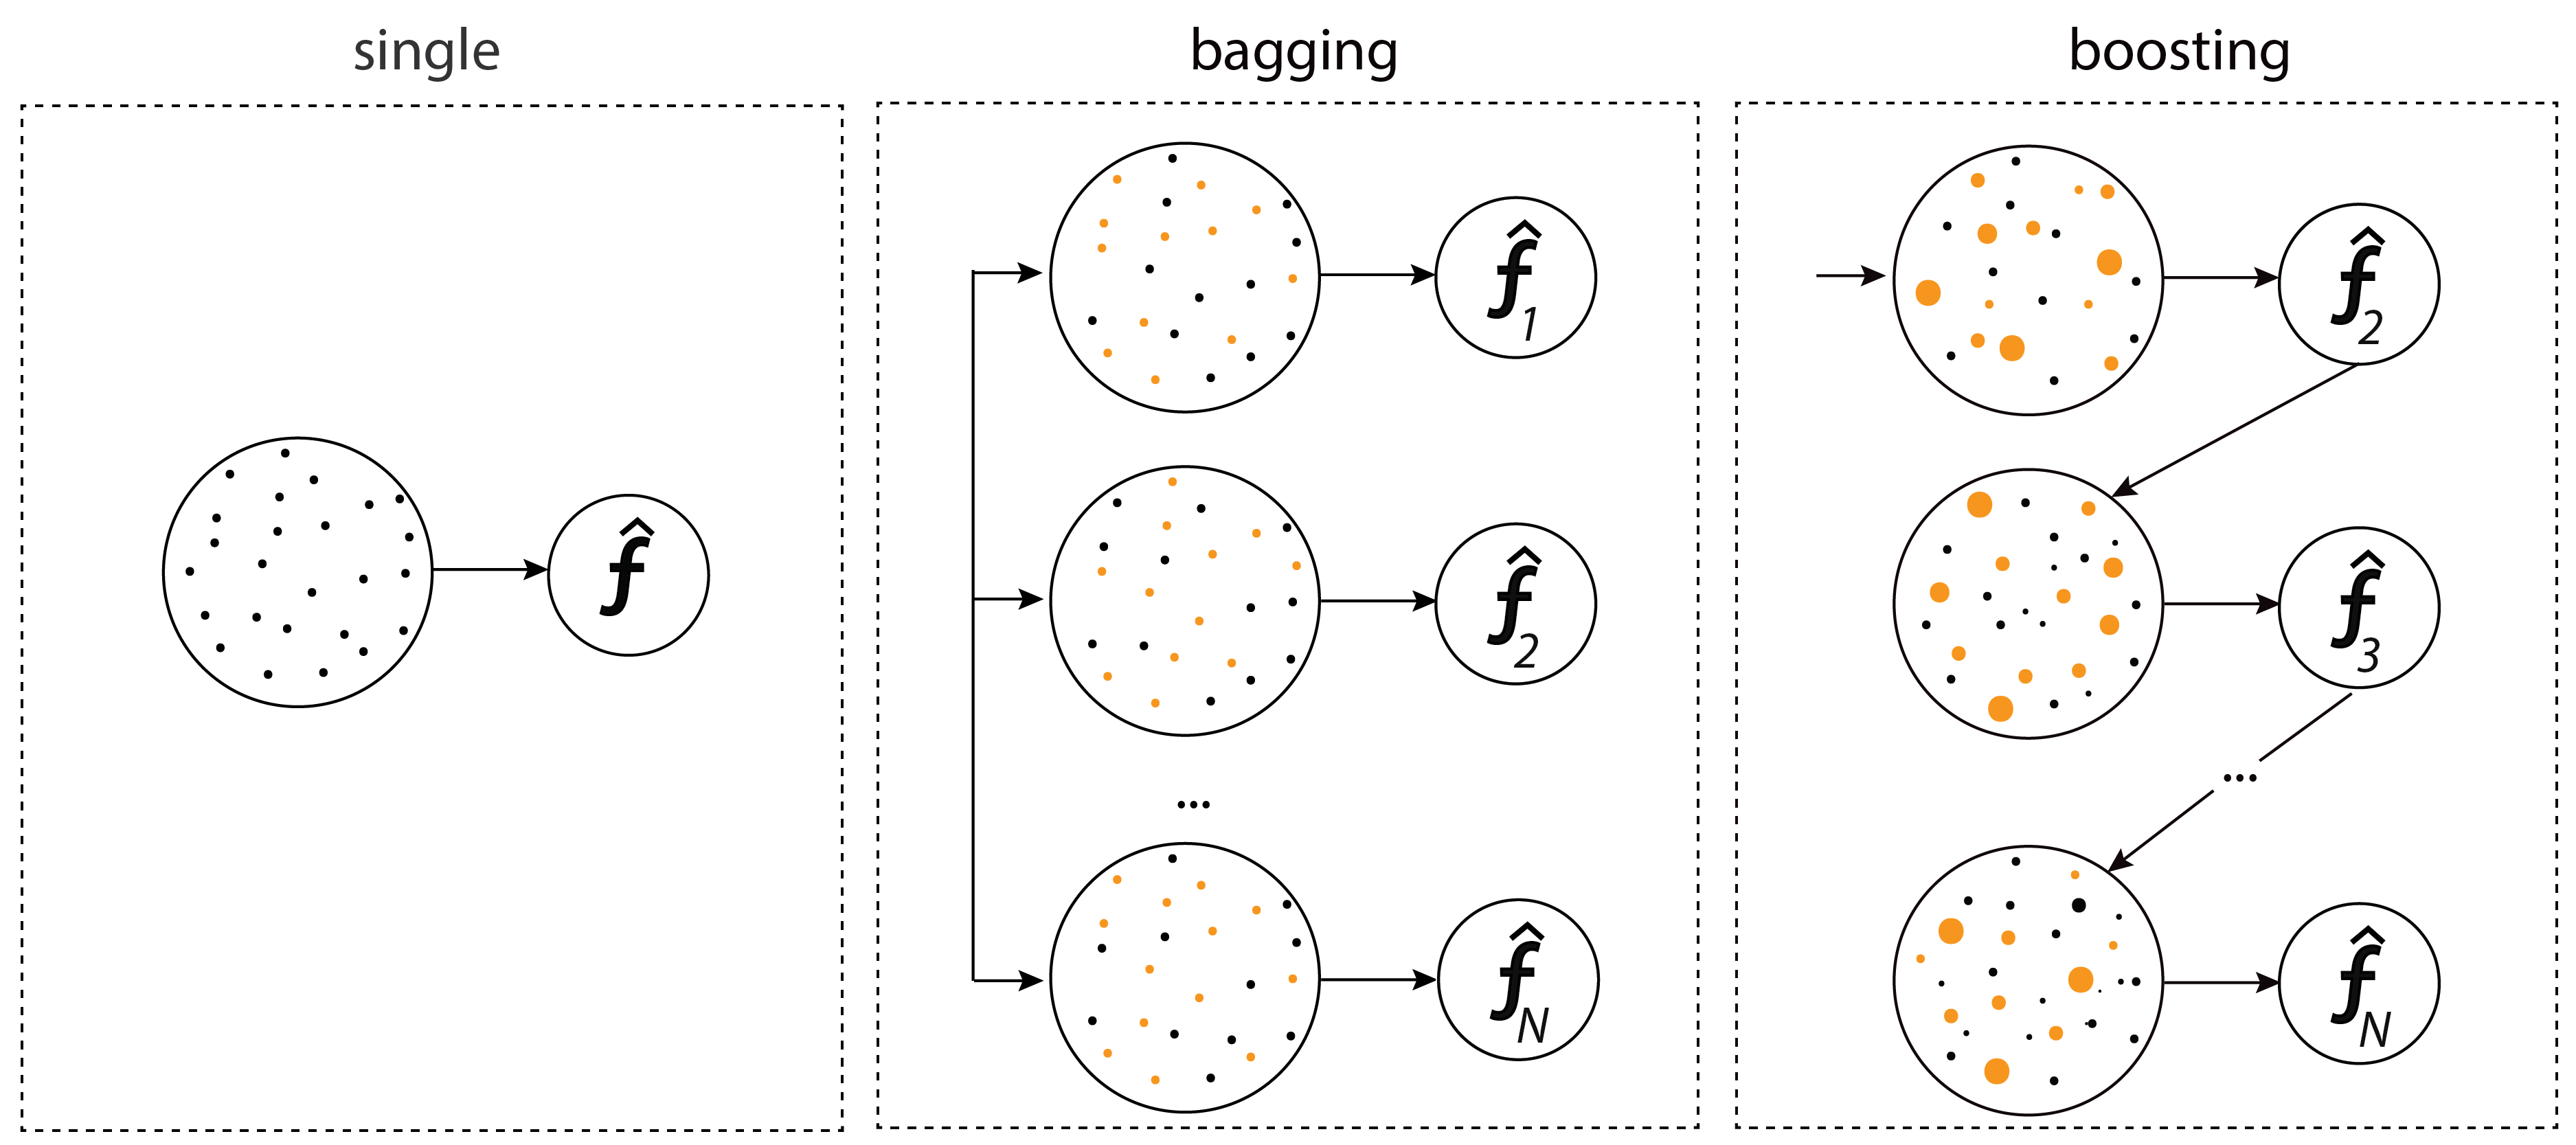

http://incredible.ai/machine-learning/2015/10/25/Bias-Variance-Tradeoff-Ensemble/

#### Boosting 대표 모델 : AdaBoost

1. 학습 데이터 N개로부터 중복을 허용하여 무작위로 샘플 데이터 N개를 추출한다.
2. 샘플 데이터에서 중복을 허용하지 않고, 무작위로 X 값(input feature) d개를 선택한다.
3. d개의 feature에 대해 Decision Tree를 수행한다.
4. 오차가 발생한 데이터가 샘플링할 때 더욱 잘 추출되도록 가중치를 부여한다.
5. 위의 1-3 과정을 K번 수행한다.

- 이외에도 다양한 부스팅 계열 모델 (Ada Boost, Gradient Boosting, XGBoost, LGBM, CatBoost)이 존재한다. 

`AdaBoostClassifier(base_estimator, n_estimators, learning_rate, algorithm, random_state)`

주요 parameter:
  - `base_estimator` : 모델을 정해주는 파라미터, (기본 값= DecisionTreeClassifier(max_depth=1)) 
  - `n_estimators` : 앙상블의 약한 학습기 개수, (기본 값=50)
  - `learning_rate` : 이전 트리의 오차를 얼마나 강하게 보정할 것인지를 설정, learning rate가 클수록 보정을 강하게 한다. (기본값=1.0)
  - `algorithm` : SAMME과 SAMME.R 중에서 선택 가능, (기본 값=SAMME.R),  
  SAMME.R은 예측값이 아닌 클래스 확률값에 기반하므로 base_estimator가 클래스 확률 계산을 지원하는 경우에 사용이 가능하다. SAMME으로 설정할 경우에 학습기를 업데이트 할 때 클래스 예측으로 에러를 계산하고, SAMME.R으로 설정할 경우에 클래스 예측 확률로 에러를 계산한다. SAMME.R 기반 모델이 SAMME 기반 모델 보다 수행속도가 더 빠르고, 에러가 더 적은 것으로 평가받고 있다. 

참고:https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html


In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target,
                                                   test_size = 0.3,
                                                   shuffle = True, random_state=42)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# AdaBoostClassifier를 학습시키세요 
# 단 n_estimators = 9, algorithm = "SAMME.R", learning_rate = 0.5

model_ada = AdaBoostClassifier(n_estimators = 9, 
                               algorithm = 'SAMME.R', 
                               learning_rate = 0.5).fit(X_train, y_train)

In [ ]:
#랜덤포레스트와 같이 에이다 부스트의 예측기들은 estimators_에 저장된다. 
model_ada.estimators_

[DecisionTreeClassifier(max_depth=1, random_state=809576483),
 DecisionTreeClassifier(max_depth=1, random_state=329268629),
 DecisionTreeClassifier(max_depth=1, random_state=642075574),
 DecisionTreeClassifier(max_depth=1, random_state=934287977),
 DecisionTreeClassifier(max_depth=1, random_state=674532169),
 DecisionTreeClassifier(max_depth=1, random_state=946773319),
 DecisionTreeClassifier(max_depth=1, random_state=1121852118),
 DecisionTreeClassifier(max_depth=1, random_state=715423552),
 DecisionTreeClassifier(max_depth=1, random_state=2079942349)]

In [ ]:
model_ada.predict_proba(X_test)[:10]

array([[3.15567164e-07, 9.83486424e-01, 1.65132609e-02],
       [9.99871224e-01, 1.24254420e-04, 4.52182796e-06],
       [5.15705558e-16, 3.68625641e-02, 9.63137436e-01],
       [3.15567164e-07, 9.83486424e-01, 1.65132609e-02],
       [3.15567164e-07, 9.83486424e-01, 1.65132609e-02],
       [9.99871224e-01, 1.24254420e-04, 4.52182796e-06],
       [3.15567164e-07, 9.83486424e-01, 1.65132609e-02],
       [5.15705558e-16, 3.68625641e-02, 9.63137436e-01],
       [3.15567164e-07, 9.83486424e-01, 1.65132609e-02],
       [3.15567164e-07, 9.83486424e-01, 1.65132609e-02]])

In [ ]:
# 예측결과와 클래스의 확률을 비교해보세요
model_ada.predict(X_test)[:10]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1])

In [ ]:
# Ada Score
print('train_score :{:.3f}'.format(model_ada.score(X_train, y_train)))
print('test score : {:.3f}'.format(model_ada.score(X_test, y_test)))

train_score :0.905
test score : 0.978


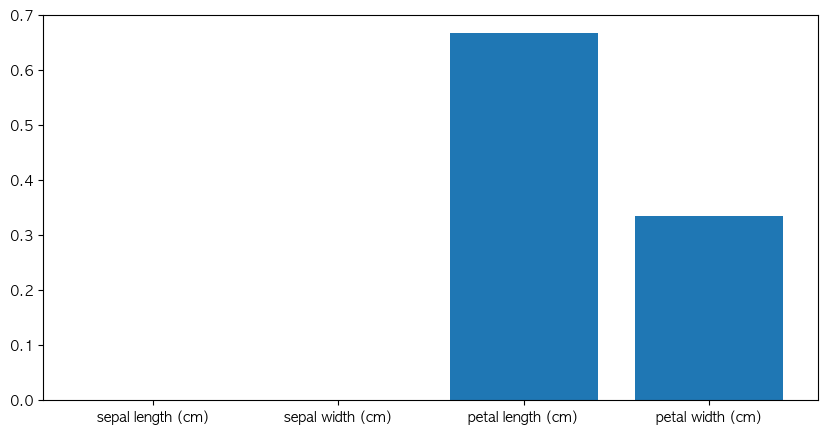

In [ ]:
# 특성 중요도 그래프 그리기
plt.figure(figsize =(10,5))
plt.bar(iris.feature_names, model_ada.feature_importances_)
plt.show()

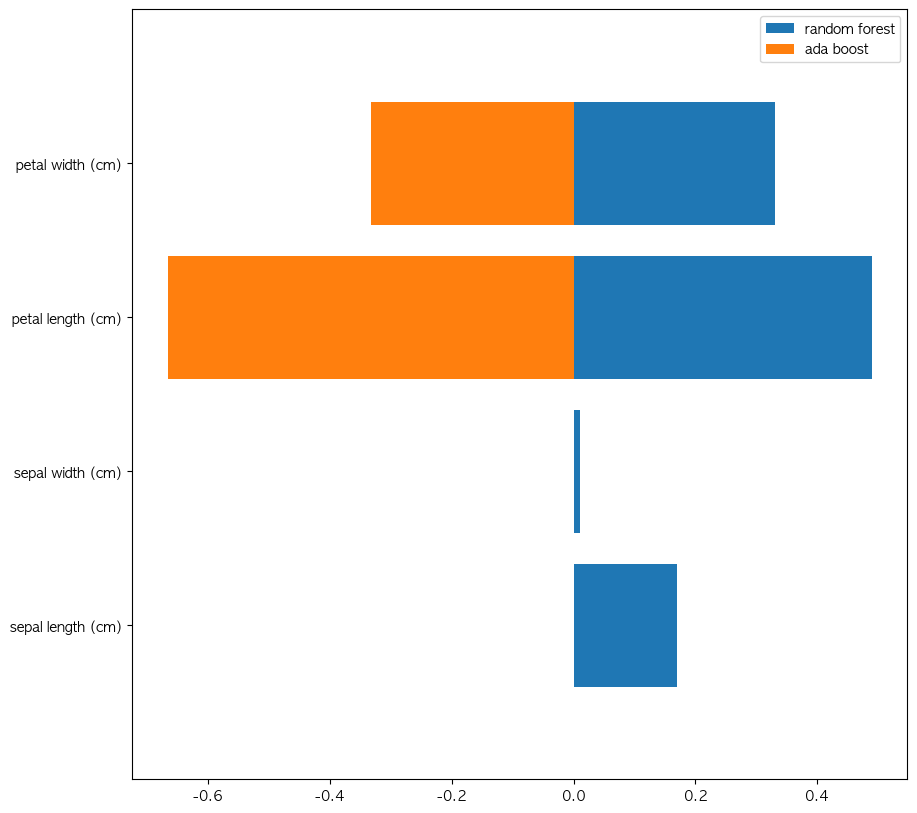

In [ ]:
# 에이다 부스트와 랜덤 포레스트의 특성 중요도 비교
plt.figure(figsize = (10,10))
X = np.arange(iris.data.shape[1])
Y1 = forest.feature_importances_
Y2 = model_ada.feature_importances_
plt.barh(X, Y1)
plt.barh(X, -Y2)
plt.yticks(X, iris.feature_names)
plt.ylim(-1, iris.data.shape[1])
plt.legend(['random forest','ada boost'])
plt.show()

#### GridSearchCV

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# AdaBoost 객체 생성
ADA = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=7)

# param_grid 설정
ada_param_grid = {"n_estimators" :[1,20,30],
                  "algorithm" : ["SAMME","SAMME.R"],                  
              "learning_rate":  [0.001, 0.01, 0.1, 0.2, 0.3,1.5],
              "base_estimator__max_depth" : [1, 3, 5]}

# Grid Search 객체 생성
gsADA = GridSearchCV(ADA, param_grid = ada_param_grid, cv=4, scoring="accuracy", verbose = 1)

# Grid Search 실행
gsADA.fit(X_train, y_train)

Fitting 4 folds for each of 108 candidates, totalling 432 fits


GridSearchCV(cv=4,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                          random_state=7),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'base_estimator__max_depth': [1, 3, 5],
                         'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 1.5],
                         'n_estimators': [1, 20, 30]},
             scoring='accuracy', verbose=1)

In [ ]:
# 최적의 파라미터 조합 출력
ADA_best = gsADA.best_estimator_
print(ADA_best)

# 최고 점수(accuracy) 출력
print(gsADA.best_score_)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.1, n_estimators=20, random_state=7)
0.9426638176638177


## 모델링 실습 (부팅, XGB모델 사용)

In [ ]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


data = load_wine()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size = 0.2, random_state = 10)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, max_depth = 3, max_features = 1)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9166666666666666

In [ ]:
# 강사님꺼
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


data = load_wine()

In [ ]:
X = data['data']

In [ ]:
y = data['target']

In [ ]:
# 1. voting 
from sklearn.ensemble import VotingClassifier 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier 

# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# scale 
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Voting Classifier 만들기 
lr = LogisticRegression()
dt = DecisionTreeClassifier()
svm = SVC()

voting_cls = VotingClassifier(
                            estimators = [('LR', lr), ('DT', dt), ('SVM', svm)],
                            voting = 'hard' # hrar : 확률, 확률 지원 안되는 모델은 오류남
)

# 학습
voting_cls.fit(X_train, y_train)

# 평가
y_pred = voting_cls.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
voting_cls.fit(X_train, y_train)

VotingClassifier(estimators=[('LR', LogisticRegression()),
                             ('DT', DecisionTreeClassifier()), ('SVM', SVC())])

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 1)

xgb_model.fit(X_train, y_train)
xgb_model.score(X_test, y_test)

0.9166666666666666

In [ ]:
# 강사님꺼

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


data = load_wine()

In [ ]:
X = data['data']

In [ ]:
y = data['target']

In [ ]:
from xgboost import XGBClassifier 




In [ ]:
from xgboost import XGBClassifier 
from sklearn.model_selection import RandomizedSearchCV 
# 트리모델이라 스케일링 안함, 수치데이터라 인코딩 안함

# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# XGBoost 
model = XGBClassifier()

# RandomizedSearchCV

# 탐색할 하이퍼파라미터의 범위를 설정합니다.
# 가장 많이 쓰는 파라미터
param_dist = {
    'n_estimators': np.arange(100, 1000, 100),  # 트리 개수
    'max_depth': np.arange(3, 10),              # 트리 깊이
    'learning_rate': [0.01, 0.1, 0.2],          # 학습률
    'subsample': [0.5, 0.8, 1.0],               # 샘플데이터 만들 때 5할만 만든다, 8할만 만든다, 100% 다 쓴다
    'colsample_bytree': [0.5, 0.8, 1.0],        # 전체 데이터 중 반만 써서 트리 만들겠다, 8할만 써서 트리 만들겠다, 다써서 트리 만들겠다
    'gamma': [0, 1, 5]                          # 손실 규제 (많이 넣으면 세게 준다)
}


random_search = RandomizedSearchCV(model, param_distributions = param_dist, n_iter = 10, scoring = 'accuracy',
                                cv = 3, verbose = 1)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   param_distributions={'colsample_bytree': [0.5, 0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900]),
                                        'subsample': [0.5, 0.8, 1.0]},
                   scoring='accuracy', verbose=1)

In [ ]:
random_search.best_params_

{'subsample': 0.5,
 'n_estimators': 400,
 'max_depth': 5,
 'learning_rate': 0.01,
 'gamma': 0,
 'colsample_bytree': 1.0}

In [ ]:
random_search.best_score_

0.9787234042553191

In [ ]:
import pandas as pd
pd.DataFrame(random_search.cv_results_)

In [ ]:
# 테스트 데이터로 모델의 성능을 평가합니다.
y_pred = random_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy: ", accuracy)

Test accuracy:  1.0
